In [1]:
import os
import numpy as np
import sklearn.metrics
from dotenv import load_dotenv
import pandas as pd
from lib.utils import enzyme_split30_preprocessing, read_h5, apply_embedding, read_fasta, calculate_f1, bootstrap_statistic, round_to_significance

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
import joblib

In [2]:
mode = "test"

In [3]:
load_dotenv()
if mode == "train":
    path_to_non_enzymes = os.getenv("FASTA_NON_ENZYMES", "fasta ne not found")
    path_to_enzyme_csv = os.getenv("CSV30_ENZYMES", "csv 30 e not found")
    path_to_prott5_ne = os.getenv("PROTT5_NON_ENZYMES", "prot ne not found")
    path_to_prott5 = os.getenv("PROTT5_ENZYMES_SPLIT_30", "prot e not found")
elif mode == "test":
    path_to_non_enzymes = os.getenv("TEST_FASTA_NON_ENZYMES", "fasta ne not found")
    path_to_enzyme_csv = os.getenv("TEST_CSV_ENZYMES", "csv e not found")
    path_to_prott5_ne = os.getenv("TEST_PROTT5_NON_ENZYMES", "prot ne not found")
    path_to_prott5 = os.getenv("TEST_PROTT5_ENZYMES", "prot e not found")



In [4]:
enzymes=pd.read_csv(path_to_enzyme_csv, delimiter=",")
print("RAW ENZYMES SIZE: " + str(enzymes.count()))
enzymes = enzyme_split30_preprocessing(enzymes)
print("PREPROCESSED ENZYMES SIZE: " + str(enzymes.count()))

RAW ENZYMES SIZE: Entry        392
EC number    392
Sequence     392
dtype: int64
PREPROCESSED ENZYMES SIZE: ID              334
EC number       334
Sequence        334
Enzyme class    334
dtype: int64


In [5]:
enzymes = apply_embedding(read_h5(path_to_prott5), enzymes)
enzymes.head()

,ID,Embedding,EC number,Sequence,Enzyme class
0,A0A011QK89,"[0.00311, 0.02321, 0.0498, 0.0365, -0.01602, 0...",1.1.99.2,MESIEAVVIGAGVVGLACARELARRGFETVILERHGAFGTETSARN...,1
1,A0A067XR63,"[0.03723, 0.079, 0.021, -0.03314, 0.003582, -0...",2.4.1.207,MNAEGGNLHREFEITWGDGRARIHNNGGLLTLSLDRASGSGFRSKN...,2
2,A0A067XRK9,"[0.00723, 0.03946, -0.004307, -0.0265, 0.01344...",2.4.1.207,MASSLTLPMAMAFTLLALSFASAMGGSMNSSRFDELFQPSWAFDHF...,2
3,A0A067YMX8,"[0.01488, 0.07574, 0.01659, -0.02148, 0.00532,...",2.4.1.207,MAASPYSIFAVQLLLLASWMLSSSSSNFNQDFNIAWGGGRARILNN...,2
4,A0A075HNX4,"[0.02202, -0.02039, -0.00807, -0.01078, 0.0085...",1.1.3.20,MAQGAQRKNFGHNQILRPSAAYTPVDEQEVLQILDRHRGQRIRAVG...,1


In [6]:
non_enzymes = read_fasta(path_to_non_enzymes)
print("NON-ENZYMES SIZE: " + str(non_enzymes.count()))
non_enzymes.head()

NON-ENZYMES SIZE: ID          9876
Sequence    9876
dtype: int64


,ID,Sequence
0,P86725,MGYFPYLAVFVCLLASGDAQWKGLRGSTKASWVRVVSPTLNVTQEA...
1,A3EXD3,MDDSMDLDLDCVIAQPSSTIVMMPLSPISTRKRRRHPMNKRRYAKR...
2,P25602,MTYKLDRNSLRQQVMSPQSNASENIINLSSPNNYKQWLYGIETAAE...
3,P08611,DVPKSDQFVGLM
4,P08452,MLGRSLTSVLIVPTGIGCAVGGYAGDALPLARAIASVSDRLITHPN...


In [7]:
non_enzymes = apply_embedding(read_h5(path_to_prott5_ne), non_enzymes)
non_enzymes.head()

,ID,Embedding,Sequence
0,A0A023FF81,"[-0.0002077, 0.0411, 0.0986, 0.01291, -0.03146...",MTSHSAVRIAIFAVIALHSIFECLSKPQILQRTDKSTDSEWDPQTC...
1,A0A023PXB0,"[0.03284, 0.03445, 0.00204, 0.01518, -0.0348, ...",MFINGFVNYPVRTPPNDLLQVVLHGFLRCPLDGSQVDSIGIGHTVH...
2,A0A023PXD9,"[0.04263, 0.0853, 0.045, 0.0314, -0.04996, -0....",MIKKSRTYYPSFGAYFHLLPAHPNAHSVTLLFGIFRSSPFLLLFLL...
3,A0A023PXF5,"[-0.005157, -0.02013, 0.04657, 0.02606, -0.079...",MQVLIGTKLVTEGIDIKQLMMVIMLDNRLNIIELIQGVGRLRDGGL...
4,A0A023PXF8,"[0.0724, 0.0921, 0.0224, -0.05362, -0.05472, -...",MRIQKQQYTISSNSRINLLGILVLNVVCGKSSIFFSHPQRLGKLGG...


In [8]:
# Split data
enzymes["Label"] = 1
non_enzymes["Label"] = 0

bin = pd.concat([enzymes[["Label", "Embedding"]], non_enzymes[["Label", "Embedding"]]], ignore_index=True)

bin = bin.sample(frac=1, random_state=42).reset_index(drop=True)

X = [value.tolist() for value in bin["Embedding"]]
y = bin["Label"]
if mode == "train":
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    y_test = np.array(y_test)
elif mode == "test":
    X_test = X
    y_test = y
    y_test = np.array(y_test)

In [9]:
if mode == "train":
    k = 7
    knn_classifier = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn_classifier.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = knn_classifier.predict(X_test) # y_pred are predicted labels for embeddings at index
elif mode == "test":
    knn_classifier = joblib.load('./var/level0_prott5_knn.pkl')
    y_pred = knn_classifier.predict(X_test) # y_pred are predicted labels for embeddings at index



In [10]:
with open(f'./var/{mode}_knn_prott5_y_pred.txt', 'w') as file:
    for label in y_pred:
        file.write(f"{label}\n")
with open('./var/{mode}_knn_prott5_y_test.txt', 'w') as file:
    for label in y_test:
        file.write(f"{label}\n")

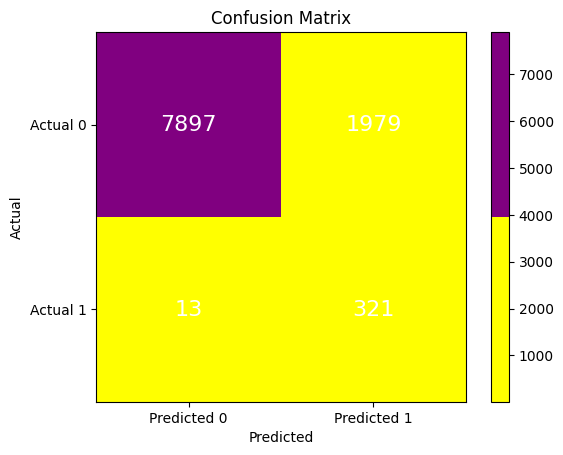

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
cm = confusion_matrix(y_test, y_pred)
# Define custom colors (e.g., green and purple)
colors = ['yellow', 'purple']

# Create a colormap using custom colors
cmap = mcolors.ListedColormap(colors)

# Plot the confusion matrix heatmap
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.colorbar()
plt.xticks([0, 1], ["Predicted 0", "Predicted 1"])
plt.yticks([0, 1], ["Actual 0", "Actual 1"])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='white', fontsize=16)

plt.show()

In [12]:
initial_f1 = calculate_f1(np.array(y_test), y_pred)
mean_f1, se_f1, ci_95 = bootstrap_statistic(y_test, y_pred, calculate_f1)
rounded_mean_f1, rounded_se_f1 = round_to_significance(mean_f1, se_f1)

[0.810871694417238, 0.8088148873653281, 0.8029382957884426, 0.8006856023506367, 0.8068560235063664, 0.7968658178256611, 0.8032321253672869, 0.8032321253672869, 0.8127326150832517, 0.8024485798237022, 0.8137120470127326, 0.7996082272282078, 0.8002938295788443, 0.8007835455435848, 0.810871694417238, 0.8117531831537709, 0.8128305582761998, 0.8017629774730657, 0.806464250734574, 0.8081292850146915, 0.8070519098922625, 0.8003917727717924, 0.8034280117531831, 0.7986287952987268, 0.8032321253672869, 0.8001958863858962, 0.8060724779627815, 0.8034280117531831, 0.8041136141038198, 0.8116552399608227, 0.8095004897159648, 0.8030362389813909, 0.8060724779627815, 0.8069539666993143, 0.8006856023506367, 0.8067580803134182, 0.8019588638589618, 0.8001958863858962, 0.8098922624877571, 0.8065621939275222, 0.8004897159647405, 0.8022526934378059, 0.8075416258570031, 0.8113614103819784, 0.7948090107737511, 0.8063663075416259, 0.8029382957884426, 0.8077375122428991, 0.8051909892262488, 0.8012732615083251, 0.

In [13]:
print(f"PROTT5 KNN:")
print(f"  - Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"  - Initial F1 Score: {initial_f1:.2f}")
print(f"  - MCC: {matthews_corrcoef(y_test, y_pred)}")
print(f"  - Mean F1 ± SE F1: {rounded_mean_f1} ± {rounded_se_f1}")
print(f"  - 95% CI: [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")

PROTT5 KNN:
  - Accuracy: 0.8048971596474045
  - Initial F1 Score: 0.80
  - MCC: 0.32390755352522915
  - Mean F1 ± SE F1: 0.805 ± 0.0039
  - 95% CI: [0.80, 0.81]


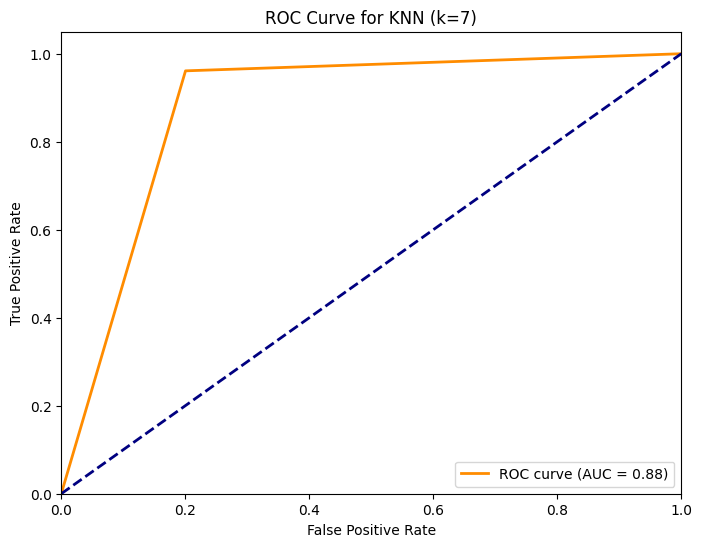

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the AUC (Area Under the ROC Curve)
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for KNN (k=7)')
plt.legend(loc='lower right')
plt.show()

In [15]:
if mode == "train":
    joblib.dump(knn_classifier, './var/level0_prott5_knn.pkl')